## Calculate the fill factor for an LSST field of view.

Uses the camera geometry that is intended to represent the actual focal plane (or at least, one vendor's version of the focal plane geometry). 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

# For the footprint generation and conversion between galactic/equatorial coordinates.
from lsst.sims.utils import haversine, ObservationMetaData
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import chipNameFromPupilCoords

import lsst.sims.utils as sims_utils

mapper = LsstSimMapper()
camera = mapper.camera
epoch = 2000.0
site = sims_utils.Site('LSST')

In [2]:
# Set up pupil coordinate points to iterate over (to calculate fill factor)
testrange = 2.2
spacing = 0.05
xcen = 0
ycen = 0
xi = np.arange(xcen-np.radians(testrange), xcen+np.radians(testrange), np.radians(spacing))
yi = np.arange(ycen-np.radians(testrange), ycen+np.radians(testrange), np.radians(spacing))
x = []
y = []
for i in itertools.product(xi, yi):
    x.append(i[0])
    y.append(i[1])
x = np.array(x)
y = np.array(y)
rotation_angles = np.arange(0, 361, 2)
xr = {}
yr = {}
for r in rotation_angles:
    xr[r] = x * np.cos(np.radians(r)) + y * np.sin(np.radians(r))
    yr[r] = -1 * x * np.sin(np.radians(r)) + y * np.cos(np.radians(r))

x/y match ra/dec in original, unrotated frame. xr[r]/yr[r] match ra/dec in original rotated frame, but add rotation angle to camera. 

In [3]:
visr = {}
for r in rotation_angles:
    # Calculate 'visibility'
    chipNames = chipNameFromPupilCoords(xr[r], yr[r], camera=camera)
    vis = np.zeros(len(chipNames))
    for i, chip in enumerate(chipNames):
        if chip is not None:
            vis[i] = 1
    visr[r] = vis

In [4]:
# Let's just confirm pupil coordinates are basically just the same as ra/dec offsets from boresight
import palpy 
ra = np.array([np.radians(1.75)])
dec = np.array([np.radians(1.75)])
xp, yp = palpy.ds2tpVector(ra, dec, 0, 0)
print ra, dec, xp, yp

[ 0.03054326] [ 0.03054326] [ 0.03055276] [ 0.03056702]


In [5]:
# Calculate % fill factor, for a particular assumed (circular) fov .. at a particular rotation angle.
fillfactor = np.zeros(len(rotation_angles))
for i, r in enumerate(rotation_angles):
    area_degsq = 9.6
    innerradius = np.sqrt(area_degsq/np.pi)
    #print 'inner radius matching area_degsq for circle', innerradius
    sep = np.degrees(sims_utils.haversine(xr[r], yr[r], xcen, ycen))
    #print 'max distance from center used for chip calculation', sep.max()
    incircle = np.where(sep < innerradius)[0]
    onchip = np.where(visr[r][incircle] == 1)[0]
    fillfactor[i] = len(visr[r][onchip]) / float(len(visr[r][incircle]))
print 'fill factor variation with rotation angle', np.std(fillfactor), fillfactor.min(), fillfactor.max()
print 'mean fill factor', fillfactor.mean()

vis = visr[0]
area_degsq = 9.6
innerradius2 = 1.75
print 'inner radius matching area_degsq for circle', innerradius2
sep = np.degrees(sims_utils.haversine(x, y, xcen, ycen))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < innerradius2)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

outerradius = 2.06
print 'outer radius', outerradius
sep = np.degrees(sims_utils.haversine(x, y, xcen, ycen))
print 'max distance from center used for chip calculation', sep.max()
incircle = np.where(sep < outerradius)[0]
onchip = np.where(vis[incircle] == 1)[0]
fillfactor = len(vis[onchip]) / float(len(vis[incircle]))
print 'fill factor', fillfactor

fill factor variation with rotation angle 0.00380840207856 0.882337594573 0.907122358466
mean fill factor 0.888401537679
inner radius matching area_degsq for circle 1.75
max distance from center used for chip calculation 3.11088748063
fill factor 0.907556478837
outer radius 2.06
max distance from center used for chip calculation 3.11088748063
fill factor 0.743124415341


In [6]:
# Calculate overall 'visibility', over all rotation angles.
# The ra/dec equivalent for each point in the field of view can be translated using x/y. 
# xr[r]/yr[r] are the equivalent pupil coordinates for the same RA/Dec, once a camera rotation of r (-r?) is applied.
allvis = np.zeros(len(visr[0]), float)
for r in rotation_angles:
    allvis += visr[r]
allvis = allvis/180.

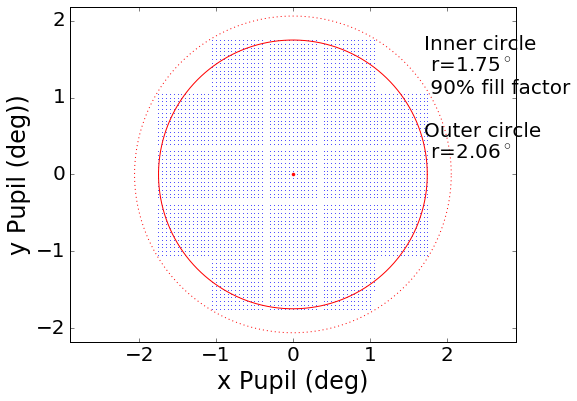

In [7]:
# Plot single rotation angle.

vis = visr[0]
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update(inline_rc)
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 22

plt.figure()
plt.axis('equal')
condition = np.where(vis == 1)[0]
#plt.plot(np.degrees(x), np.degrees(y), 'g.', markersize=0.2)
plt.plot(np.degrees(x[condition]), np.degrees(y[condition]), 'b.', markersize=0.8)
plt.plot(0, 0, 'r.')
plt.xlabel('x Pupil (deg)', fontsize='larger')
plt.ylabel('y Pupil (deg))', fontsize='larger')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(innerradius*np.cos(theta)+np.degrees(xcen), innerradius*np.sin(theta)+np.degrees(ycen), 'r-')
plt.plot(outerradius*np.cos(theta)+np.degrees(xcen), outerradius*np.sin(theta)+np.degrees(ycen), 'r:')
#plt.xlim(fieldra+offset-sep.max()/2.0, fieldra+offset+sep.max()/2.0)
plt.ylim(np.degrees(xcen)-sep.max()*.7, np.degrees(ycen)+sep.max()*.7)
xco = 0.74
plt.figtext(xco, 0.8, 'Inner circle')
plt.figtext(xco, 0.75, r' r=1.75$^\circ$')
plt.figtext(xco, 0.7, ' 90%s fill factor' %('%'))
plt.figtext(xco, 0.6, 'Outer circle')
plt.figtext(xco, 0.55, r' r=2.06$^\circ$')
#plt.figtext(xco, 0.5, ' 71%s fill factor' %('%'))
plt.savefig('focalplane.pdf', format='pdf')
plt.savefig('focalplane.png', format='png')

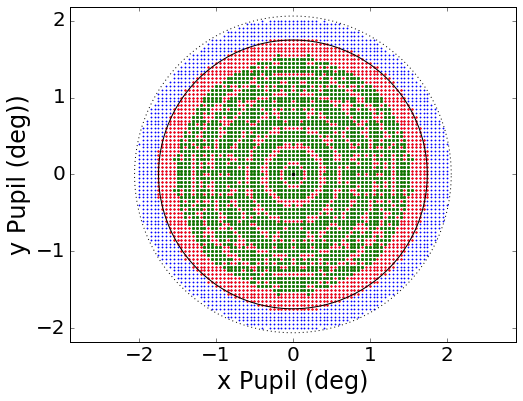

In [20]:
# Plot combination of all rotation angles.
vis = allvis
plt.figure()
plt.axis('equal')
condition = np.where(vis >= (1/180.))[0]
#plt.plot(np.degrees(x), np.degrees(y), 'g.', markersize=0.2)
plt.plot(np.degrees(x[condition]), np.degrees(y[condition]), 'b.', markersize=2.5)
condition = np.where(vis >= .6)[0]
plt.plot(np.degrees(x[condition]), np.degrees(y[condition]), 'r.', markersize=3.5)
condition = np.where(vis >= .9)[0]
plt.plot(np.degrees(x[condition]), np.degrees(y[condition]), 'g.', markersize=5)
plt.plot(0, 0, 'k.')
plt.xlabel('x Pupil (deg)', fontsize='larger')
plt.ylabel('y Pupil (deg))', fontsize='larger')
theta = np.arange(0, 2*np.pi, 0.01)
plt.plot(innerradius*np.cos(theta)+np.degrees(xcen), innerradius*np.sin(theta)+np.degrees(ycen), 'k-')
plt.plot(outerradius*np.cos(theta)+np.degrees(xcen), outerradius*np.sin(theta)+np.degrees(ycen), 'k:')
#plt.xlim(fieldra+offset-sep.max()/2.0, fieldra+offset+sep.max()/2.0)
plt.ylim(np.degrees(xcen)-sep.max()*.7, np.degrees(ycen)+sep.max()*.7)
#plt.figtext(xco, 0.5, ' 71%s fill factor' %('%'))
plt.savefig('allfocalplane.pdf', format='pdf')
plt.savefig('allfocalplane.png', format='png')

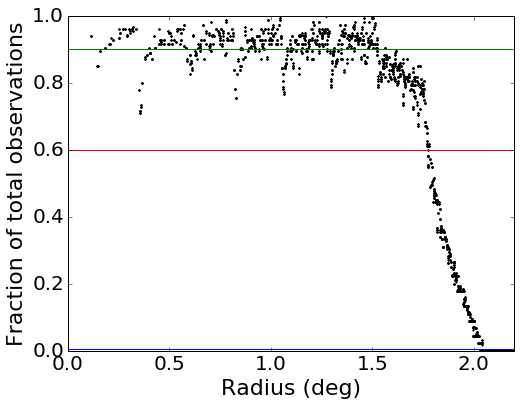

In [26]:
# And plot as function of radius.
allvis
radius = np.degrees(sims_utils.haversine(x, y, xcen, ycen))
plt.plot(radius, allvis, 'k.', markersize=3)
plt.axhline(0.9, c='g')
plt.axhline(0.6, c='r')
plt.axhline(1/180., c='b')
plt.xlim(0, 2.2)
plt.ylim(0, 1)
plt.xlabel('Radius (deg)')
plt.ylabel('Fraction of total observations')

In [28]:
# And zoom in even more, to check raft/ccd spacing along a single row.
testrange = 1.75
spacing = 0.00005
xi = np.arange(xcen - np.radians(testrange),
                xcen + np.radians(testrange), np.radians(spacing))
yi = np.zeros(len(xi)) + ycen

# Calculate 'visibility'
chipNames = chipNameFromPupilCoords(xi, yi, camera=camera)
xvis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        xvis[i] = 1

gap - onchip - gap .. [  43.92  798.66   46.08  799.02   50.04  799.38   43.92  799.74   44.82
  799.92   50.22  799.92   44.82  799.92   44.64  800.1    51.12  799.92
   44.1   799.56   44.46  799.38   49.68  799.02   45.36  798.66   44.1 ]
fill factor in x direction, @ center: 0.948628571429


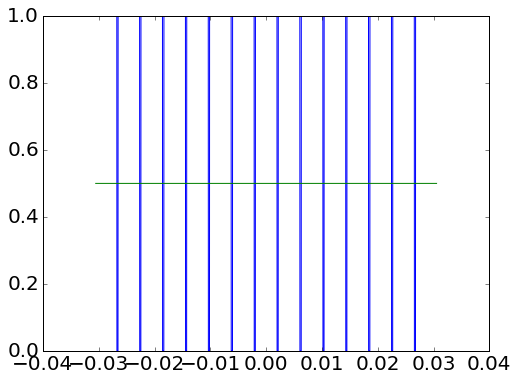

In [30]:
condition = np.where(np.diff(xvis) != 0)[0]
print 'gap - onchip - gap ..', np.diff(np.degrees(xi[condition])*60.*60.)
onchip = (np.abs(xi)<1.75)
condition = (xvis == 1)
fill = len(xvis[condition]) / float(len(xvis[onchip]))
print 'fill factor in x direction, @ center:', fill

plt.plot(xi, xvis)
plt.plot(xi[onchip], np.zeros(len(xi[onchip]))+0.5)

In [31]:
# And zoom in even more, to check raft/ccd spacing in column direction.
testrange = 1.75
spacing = 0.00005
yi = np.arange(ycen - np.radians(testrange),
                ycen + np.radians(testrange), np.radians(spacing))
xi = np.zeros(len(yi)) + xcen

# Calculate 'visibility'
chipNames = chipNameFromPupilCoords(xi, yi, camera=camera)
yvis = np.zeros(len(chipNames))
for i, chip in enumerate(chipNames):
    if chip is not None:
        yvis[i] = 1

gap - onchip - gap .. [  30.42  813.06   30.24  813.42   34.74  813.78   31.86  813.96   30.96
  814.32   33.48  814.32   32.04  814.5    29.52  814.32   36.54  814.32
   30.78  814.14   28.8   813.78   37.26  813.42   29.52  813.06   31.32]
fill factor in y direction, @ center: 0.96449949285


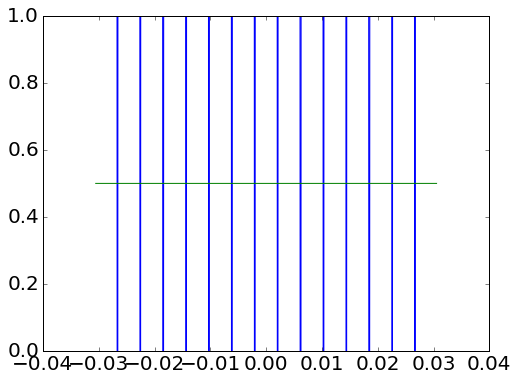

In [32]:
condition = np.where(np.diff(yvis) != 0)[0]
print 'gap - onchip - gap ..', np.diff(np.degrees(yi[condition])*60.*60.)
onchip = (np.abs(yi)<np.radians(1.75))
condition = (yvis == 1)
fill = len(yvis[condition]) / float(len(yvis[onchip]))
print 'fill factor in y direction, @ center:', fill

plt.plot(yi, yvis)
plt.plot(yi[onchip], np.zeros(len(yi[onchip]))+0.5)

In [33]:
# From documentation:
ccdx = 40*0.2*100
ccdy = 40.72*0.2*100
ccdgapx = 45
ccdgapy = 30.6
raftgapx = 50
raftgapy = 35.6
raftx = (ccdx + ccdgapx + ccdx + ccdgapx + ccdx) 
rafty = (ccdy + ccdgapy + ccdy + ccdgapy + ccdy)
print "All gap/chip/raft size information in arcseconds"
print 'ccd x/y', ccdx, ccdy
print 'ccd gap x/y', ccdgapx, ccdgapy
print 'raft x/y (w/o raft gap)', raftx, rafty
print 'raft gap x/y', raftgapx, raftgapy
ccdarea = ccdx * ccdy
raftarea = raftx * rafty
print 'ccd and raft areas', ccdarea, raftarea
fillfactor_active = (189*ccdarea) / (21.*raftarea) * 100
print 'fill factor, without raft gaps', fillfactor_active

x = 5*(3*ccdx+2*ccdgapx) + 5*raftgapx
y = 5*(3*ccdy+2*ccdgapy) + 5*raftgapy
print 'total x/y (including outside gaps)', x, y 

# if we want to make our 'raft' be contiguous squares, squares over whole focal plane
# And want raft to be square
# 'size' side
side = np.sqrt(x*y)
print 'square side length', side
raftxy = np.sqrt(x*y) / 5.0
print 'raft xy with raft gaps', raftxy
raftarea = raftxy**2
fillfactor_active = (189*ccdarea) / (21.*raftarea) * 100
print 'fill factor, with raft gaps', fillfactor_active

print 'total square degrees for outside fov', (x*y)/(3600)**2
print (2.1)**2*np.pi


All gap/chip/raft size information in arcseconds
ccd x/y 800.0 814.4
ccd gap x/y 45 30.6
raft x/y (w/o raft gap) 2490.0 2504.4
raft gap x/y 50 35.6
ccd and raft areas 651520.0 6235956.0
fill factor, without raft gaps 94.0301695522
total x/y (including outside gaps) 12700.0 12700.0
square side length 12700.0
raft xy with raft gaps 2540.0
fill factor, with raft gaps 90.8872217744
total square degrees for outside fov 12.4452160494
13.8544236023
